### 🏨 **Exploring the Causes Behind Hotel Booking Cancellations**

Hotel bookings can be canceled for many reasons — such as limited room availability, unmet guest preferences, or personal trip changes.  
Some of these causes are **actionable** (e.g., changing the room assignment or offering car parking), while others are **beyond the hotel’s control** (e.g., a guest canceling their entire trip).

<img src="Hotel.png" alt="Hotel booking" width="400">

💡 **Goal:**  Understand *why* hotel bookings get canceled — and how to identify the **root causes** using causal reasoning. This example shows how to use **causal analysis** — not just correlation — to discover which factors truly **cause** cancellations and which ones are simply **associated** with them.

***
### 🧰 Import Libraries

Before starting, make sure all the required libraries are installed. 

You will also need to install pygraphviz by runing the following code in Anaconda terminal:

`conda install -c conda-forge pygraphviz`

To install [doWhy](https://www.pywhy.org/dowhy/v0.13/index.html), run:

`pip install dowhy`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dowhy
import networkx as nx
from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

***
### 📂 Read Booking Data from URL

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

***
### 🧮 Feature Engineering

Let's create a few new and meaningful features to reduce the dimensionality of the dataset.

- Total stay: `total_stay = stays_in_weekend_nights + stays_in_week_nights`  
- Total guests: `guests = adults + children + babies`  
- Different room assigned: `different_room_assigned = 1 if reserved_room_type != assigned_room_type else 0`

In [4]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

***
### 🧹 Data Preparation

* We remove columns that contain NULL values or have too many unique values (such as agent ID).  
* Missing values in the `country` column are imputed with the most frequent country.  
* The `distribution_channel` column is dropped since it overlaps heavily with `market_segment`.

In [5]:
# Handling missing values
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)

# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [6]:
# Dropping unneeded columns
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

In [7]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned'] = dataset['different_room_assigned'].astype(bool)
dataset['is_canceled'] = dataset['is_canceled'].astype(bool)

dataset.dropna(inplace=True)
print(dataset.columns)
dataset.iloc[:, 5:20].head(100)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,73.80,0,1,2,2.0
96,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,117.00,0,1,7,2.0
97,HB,ESP,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,196.54,0,1,7,3.0
98,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,99.30,1,2,7,3.0


***
### 🔍 Exploratory Data Analysis

In [8]:
dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   False        74947      74947               74947   
             True         29690      29690               29690   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   False                           74947  74947    74947   
             True                            29690  29690    29690   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   False                 74947              74947   
             True                  29690              29690   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   False                         74947   
             True                          29690   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   False                                 74947            74947   
             True                                  29690            29690   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   False                       74947          74947  74947   
             True                        29690          29690  29690   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   False                              74947   
             True                               29690   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   False                            74947       74947   74947   
             True                             29690       29690   29690   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   False                          74947  
             True                           29690

In [9]:
# Creating a deep copy of the dataset
dataset_copy = dataset.copy(deep=True)

#### Data imbalance visualization example

The number of cancellations `is_canceled` and the number of times a different room was assigned `different_room_assigned` are highly imbalanced. 

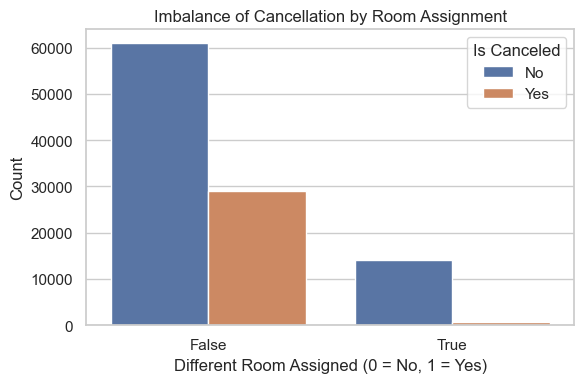

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=dataset, x="different_room_assigned", hue="is_canceled")
plt.xlabel("Different Room Assigned (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.title("Imbalance of Cancellation by Room Assignment")
plt.legend(title="Is Canceled", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

#### 📊 Calculating Expected Counts

- To explore their relationship between `different_room_assigned` and `is_canceled`, we randomly select **1,000 observations** and check how often the variables `is_canceled` and `different_room_assigned` have the same values.  
- This process is repeated **10,000 times** to calculate the expected count.  
- The result shows that both variables match about **50% of the time**, which is what we’d expect **by random chance**.  

➡️ **Conclusion:**  Statistically, we cannot conclude that assigning a different room causes cancellations. It **may or may not** influence a guest’s decision to cancel.

In [11]:
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset.sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

We now consider the scenario when there were no booking changes and recalculate the expected count.

In [12]:
# Expected Count when there are no booking changes
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

#### 📊 Causal DAG: Confounding by Booking Changes

In the 2nd case, we take the scenario when there were booking changes(>0) and recalculate the expected count.

This Directed Acyclic Graph (DAG) illustrates a causal relationship where:

<img src="DAG.png" alt="DAG" width="500">

- **`different_room_assigned`** is the **treatment**
- **`is_canceled`** is the **outcome**
- **`booking_changes`** is a **confounder** that influences both the treatment and the outcome



In [13]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

#### 🔍 Investigating the Effect of Booking Changes

- When the number of booking changes is **non-zero**, we observe a noticeable change in cancellation behavior.  
- The backdoor path from `different_room_assigned` to `is_canceled` via `booking_changes` introduces confounding.
- This suggests that **booking changes** might be influencing **room cancellations**.  
- To estimate the **true causal effect** of room reassignment on cancellations, we must **adjust for `booking_changes`**.

However, we should consider an important question:  
- Is `booking_changes` the **only confounding variable**?  
- What if there are **unobserved confounders** (factors not captured in our dataset) that affect both booking changes and cancellations?

➡️ If such hidden variables exist, our current conclusions may not hold — and the observed relationship could be misleading.

***
### ⚙️ Using DoWhy to Estimate the Causal Effect

We follow four key steps to perform causal inference using **DoWhy**:

1. **Create a Causal Graph** – define the relationships between variables.  
2. **Identify the Causal Effect** – determine which paths represent the causal relationship of interest.  
3. **Estimate the Identified Estimand** – use statistical methods to quantify the effect.  
4. **Refute the Results** – test the robustness of our findings against alternative explanations.


#### 🧭 Step 1: Create a Causal Graph

Represent your prior knowledge about the predictive modeling problem as a **causal graph** based on reasonable assumptions.  
You don’t need a complete graph at this stage — even a **partial graph** is enough for DoWhy to work with.

**Assumptions for the Causal Diagram:**

- **Market Segment**  
  - Has two levels: `"TA"` (Travel Agents) and `"TO"` (Tour Operators).  
  - It influences **Lead Time**, the number of days between booking and arrival.  
  - It may also indirectly affect **Hotel**, **Required Car Parking Spaces**, and **Total Special Requests**.

- **Country**  
  - Affects how early a customer books (→ **Lead Time**).  
  - Also influences **Meal Preference**, **Hotel Choice**, and **Special Requests**.  
  - Therefore, it indirectly affects both **room assignment** and **cancellation likelihood**.

- **Lead Time**  
  - Impacts **Days in Waiting List** — shorter lead times reduce the chance of getting a room.  
  - Longer lead times may increase **Cancellations**, as customers are more likely to change plans.  

- **Days in Waiting List**  
  - Influences whether a **Different Room** is assigned.  
  - Longer wait times can increase the chance of **Cancellation** due to customer frustration or schedule changes.

- **Previous Booking Retentions**  
  - Affect whether a guest is **Repeated** or **New**.  
  - Repeated guests are typically less likely to cancel and more likely to be reassigned if necessary.

- **Booking Changes**  
  - Directly affect whether a **Different Room** is assigned.  
  - Also directly influence the probability of **Cancellation**, since more changes can create dissatisfaction or booking errors.

- **Hotel**, **Total Special Requests**, and **Guests**  
  - These operational and behavioral variables influence both **room assignment** and **cancellation behavior**.

- **Unobserved Confounders**  
  - Represent unknown or unmeasured factors (e.g., customer preferences, staff decisions) that may simultaneously affect  
    - **Different Room Assigned**,  
    - **Guest Characteristics (e.g., Total Stay, Guests)**, and  
    - **Cancellation Likelihood**.

🧠 **Tip:** These assumptions form the basis of your **Causal Diagram** — they help DoWhy understand how variables interact and which relationships to test causally.

In [14]:
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""

##### 🧩 Defining Treatment, Outcome, and Common Causes

- **Treatment:**  
  Assigning the **same type of room** that the customer originally reserved during booking.

- **Outcome:**  
  Whether the **booking was cancelled** or not.

- **Common Causes:**  
  Variables that causally affect **both** the treatment and the outcome.  
  Based on our assumptions, the following meet this criterion:
  - `booking_changes`
  - `unobserved_confounders`

If we don’t explicitly define the causal graph (not recommended), these variables can still be passed as parameters in the function below.

**Note:**  
To help identify the causal effect, we can remove the **unobserved confounder node** from the graph. If you include it and run the `identify_effect()` method, DoWhy will correctly indicate that the causal effect **cannot be identified** due to the unobserved confounding.

#### 🧠 Create the causal model

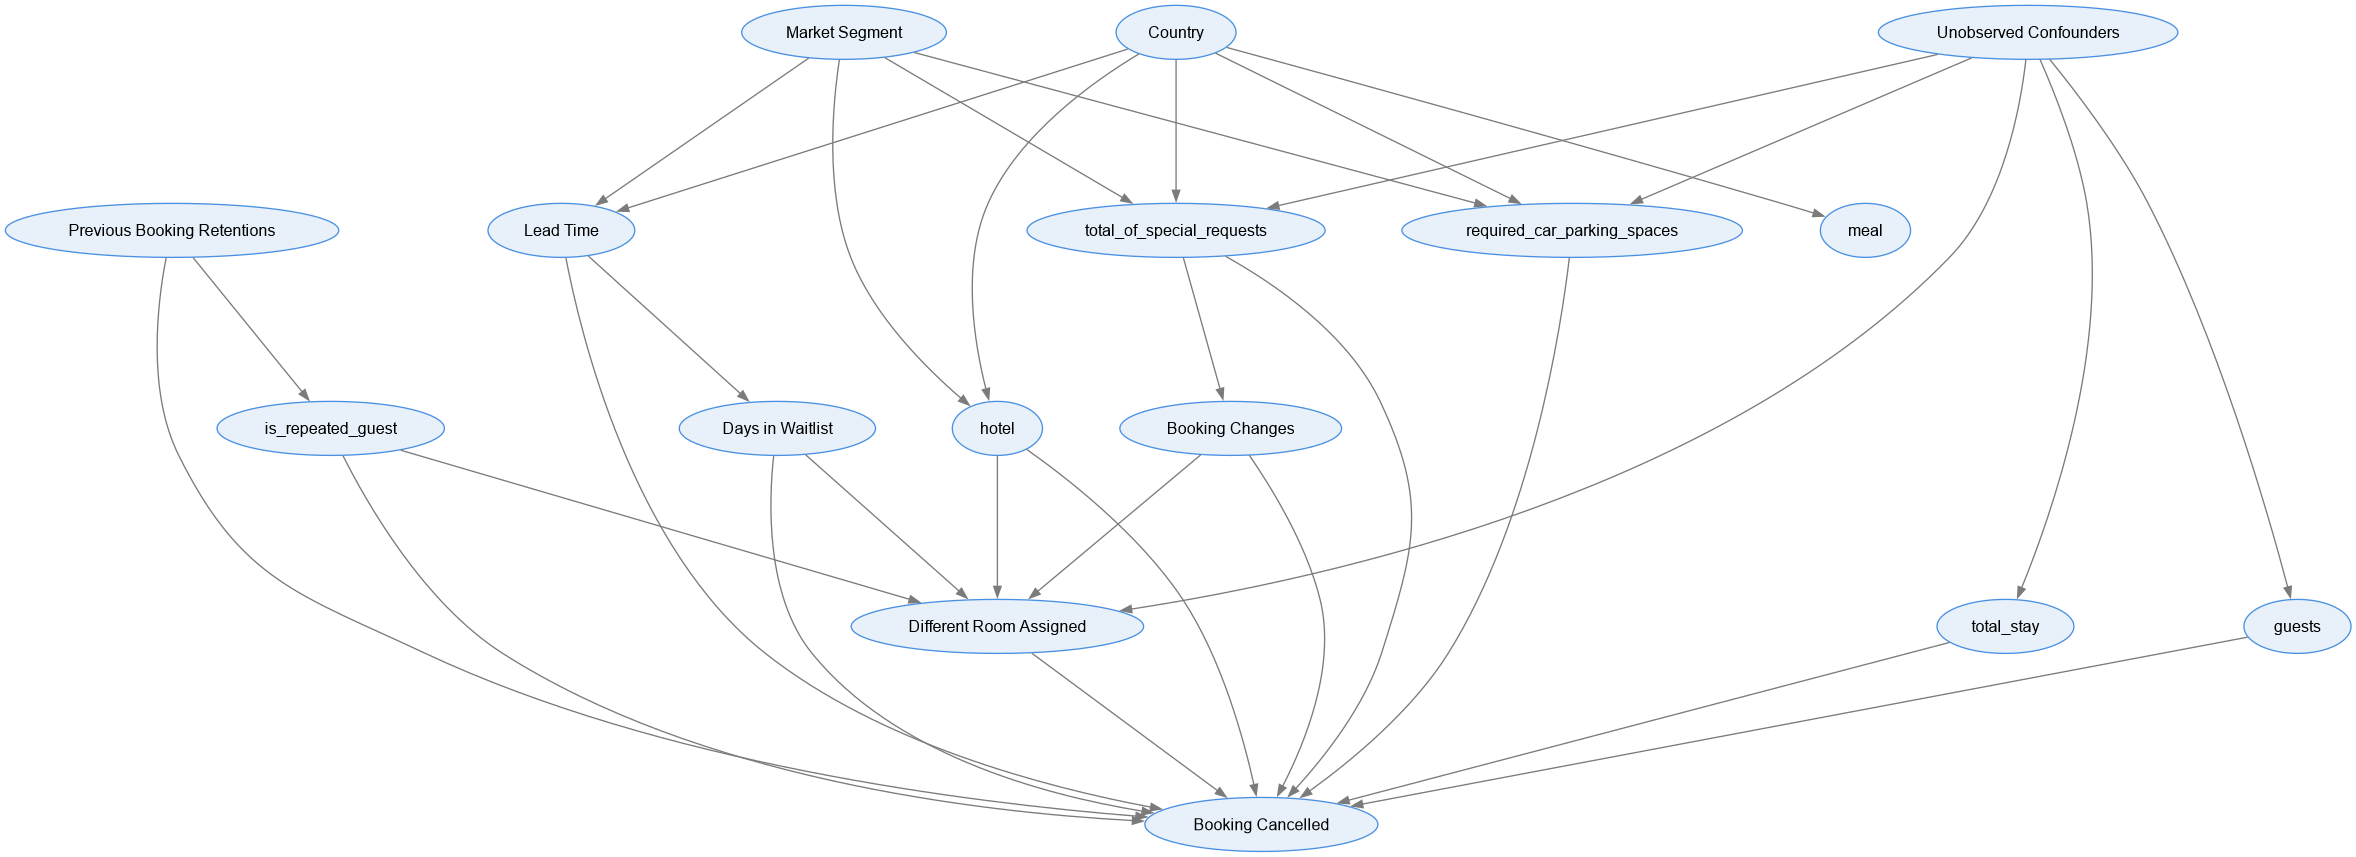

In [15]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')

# Convert NetworkX graph to PyGraphviz AGraph
G_nx = model._graph._graph
A = nx.nx_agraph.to_agraph(G_nx)

# Layout and styling for a clean top-to-bottom hierarchical graph
A.graph_attr.update(
    rankdir="TB",       # Top to Bottom layout
    ranksep="1.5",      # vertical spacing between layers
    nodesep="0.8",      # horizontal spacing between nodes
    fontname="Arial"
)

# Node appearance and text alignment
A.node_attr.update(
    fontname="Arial",
    fontsize="12",
    shape="ellipse",
    style="filled",
    fillcolor="#E8F1FA",
    color="#4A90E2",
    labelloc="c",       # center label vertically
    margin="0.15,0.10"  # padding inside nodes
)

# Edge style
A.edge_attr.update(
    arrowsize="0.8",
    color="#7B7B7B"
)

# Render and save
A.layout(prog="dot")
A.draw("causal_model.png")

# Display the image
display(Image(filename="causal_model.png"))


***
#### 🔎 Step 2: Identify the Causal Effect

We say that a **Treatment** causes an **Outcome** if changing the treatment leads to a change in the outcome **while keeping everything else constant**.

In this step, we use the **properties of the causal graph** to identify which causal effect should be estimated.

In [16]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                  ↪
──────────────────────────(E[is_canceled|days_in_waiting_list,guests,total_of_ ↪
d[different_room_assigned]                                                     ↪

↪                                                                              ↪
↪ special_requests,is_repeated_guest,total_stay,required_car_parking_spaces,ho ↪
↪                                                                              ↪

↪                                
↪ tel,lead_time,booking_changes])
↪                                
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,days_in_waiting_list,guests,total_of_special_requests,is_repeated_guest,total_stay,required_car_parking_spaces,hotel,lead_time,booking_changes,U) = P(is_canceled|different_room_assi

##### ✅ Interpreting the Causal Effect Output

- **Estimand Type**: `nonparametric-ate`  
- **Identification Method**: **Backdoor adjustment**



##### 🧠 Key Terms Explained:

- **Estimand**: A formal description of the **causal quantity** we want to estimate (e.g., the effect of one variable on another).
- **ATE (Average Treatment Effect)**: The **average difference** in the outcome if everyone were treated vs. if no one were treated.
- **Nonparametric**: No assumptions are made about the specific mathematical form of the relationship (like linear or logistic models).
- **Backdoor Adjustment**: A method to control for confounding by conditioning on variables that block non-causal (backdoor) paths in the causal graph.



##### 🔍 What This Means:

We are estimating the **causal effect** of `different_room_assigned` on whether a booking `is_canceled`.

To do this correctly, we need to control for the following observed variables:

- `required_car_parking_spaces`
- `lead_time`
- `guests`
- `total_of_special_requests`
- `booking_changes`
- `is_repeated_guest`
- `days_in_waiting_list`
- `total_stay`
- `hotel`

This set of variables blocks confounding paths and allows us to estimate the effect **without bias**, assuming no important confounders are missing. This adjustment ensures that the relationship between `different_room_assigned` and `is_canceled` reflects causality — not just correlation.

---

#### 📈 Step 3: Estimate the Identified Estimand

Once the causal effect has been identified, we move to **estimating** it using statistical or machine learning methods.

**Estimand:**  
An *estimand* is the **mathematical expression** of the causal effect we aim to estimate —  
for example, *the expected difference in booking cancellations if all customers were assigned the same room type versus if they were not*.

In simple terms, it defines **what** we want to measure before deciding **how** to measure it.

- `ATE` = Average Treatment Effect
- `ATT` = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
- `ATC` = Average Treatment Effect on Control (i.e. those who were not assigned a different room)

In [17]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting",target_units="ate")
print(estimate)

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                  ↪
──────────────────────────(E[is_canceled|days_in_waiting_list,guests,total_of_ ↪
d[different_room_assigned]                                                     ↪

↪                                                                              ↪
↪ special_requests,is_repeated_guest,total_stay,required_car_parking_spaces,ho ↪
↪                                                                              ↪

↪                                
↪ tel,lead_time,booking_changes])
↪                                
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,days_in_waiting_list,guests,total_of_special_requests,is_repeated_guest,total_stay,required_car_parking_sp

#### ✅ Interpreting Propensity Score Weighting Result

##### 🔍 What was done:
- We estimated the **causal effect** of `different_room_assigned` on `is_canceled` using **propensity score weighting**.
- This method adjusts for differences between groups by reweighting observations based on how likely they were to receive the treatment.

##### 📌 Key Details:
- **Estimand type**: `nonparametric-ate`  
  → We aim to estimate the **average treatment effect (ATE)** without assuming a specific model form.
- **Identification method**: Backdoor adjustment (using observed covariates to block confounding paths)
- **Model formula**:  `is_canceled ~ different_room_assigned + covariates`

##### 🎯 Result:
- **Estimated causal effect (ATE)**: `-0.262`
- **Interpretation**:  Assigning a different room is estimated to **reduce the cancellation rate by ~26 percentage points**, on average, **after adjusting for observed differences**.

> ✅ This suggests that reassigning rooms may lower the likelihood of cancellations, assuming all confounders were properly adjusted for.

***
### 🔁 Step 4: Refute the Results

Remember — the **causal insights** do not come directly from data, but from the **assumptions** used to build the causal graph.  
The data only helps with the **statistical estimation** of the effect.


🧠 **Why this step matters:**  
It’s important to **test whether our assumptions hold true**.  
We can do this by asking questions such as:

- What happens if there is **another common cause** influencing both the treatment and the outcome?  
- What if the **treatment itself is a placebo** and has no real effect?

These checks, called **refutations**, help ensure that our causal conclusions are **robust and trustworthy**.


***
##### 🧪 Method 1: Random Common Cause

This method adds **randomly generated covariates** to the dataset and then re-runs the causal analysis.

- If our **causal assumptions are correct**, the estimated causal effect should **not change significantly**.  
- A large change would indicate that the original model might be **sensitive to unobserved variables**.

In short, this test helps verify whether the identified causal effect is **robust** to random noise.

In [18]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:-0.2621184370401955
New effect:-0.2622310958079732
p value:0.3400000000000001



##### 🧪 What does this do?
- This method adds a **random variable** (that mimics a potential confounder) to the dataset.
- If the estimate **changes significantly**, it suggests that the original result might be **sensitive** to unmeasured confounding.
- If the estimate **remains stable**, it increases confidence that the result is **not driven by random noise**.

##### ✅ How to interpret the output:
- **If the refuted estimate is similar to the original**, then:
  > "The estimated effect is likely **robust** to hidden confounding."

- **If it changes a lot**, then:
  > "The result may be **unstable**, and hidden confounders could be influencing the outcome."


##### ✅ Interpretation:
- The estimated causal effect changed **very little** (difference ≈ `0.00007`).
- The **high p-value (0.54)** indicates that this change is **not statistically significant**.
- ✅ This suggests that the original estimate is **robust** and **not likely driven by random or unobserved confounding**.

> This strengthens our confidence in the validity of the causal effect estimate.  

***
##### 💊 Method 2: Placebo Treatment Refuter

This method randomly assigns a **placebo treatment** (a variable unrelated to the outcome) and re-runs the causal analysis.

- If our **causal assumptions are valid**, the estimated effect for this random treatment should be **close to zero**.  
- A non-zero estimate would suggest that the model may be capturing **spurious correlations** rather than true causation.

This test helps confirm that the observed causal effect is **specific to the real treatment** and not just an artifact of the data.

In [19]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.2621184370401955
New effect:0.00023615612266824737
p value:0.96



We applied the **Placebo Treatment Refuter** to test whether the estimated causal effect could be due to random chance or model artifacts.

##### 🧪 What is it?
- This method **replaces the actual treatment variable** with a **random (placebo) treatment**.
- If the model still finds a strong effect, it would suggest the original result might be spurious.



##### 📊 Refutation Output:
- **Original estimated effect**: `-0.2623`
- **New effect with placebo treatment**: `0.00027`
- **p-value**: `0.98`



##### ✅ Interpretation:
- The placebo treatment yielded a **near-zero effect**, as expected.
- The **very high p-value (0.98)** confirms that the placebo had **no meaningful effect**.
- ✅ This supports the conclusion that the **original treatment (`different_room_assigned`) has a real causal impact** on `is_canceled`.

> The placebo test increases confidence that the estimated effect is **not due to chance or model bias**.

***
##### 🔍 Method 3: Data Subset Refuter

This method splits the dataset into **multiple subsets** (similar to cross-validation) and re-estimates the causal effect for each subset.

- If our **causal assumptions are correct**, the estimated effects should be **consistent** across all subsets.  
- Large variations in estimates may indicate **model instability** or that the causal effect depends on specific data segments.

This refuter helps test the **reliability and generalizability** of the causal effect.


In [20]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:-0.2621184370401955
New effect:-0.26230703547656253
p value:0.8999999999999999



We applied the **Data Subset Refuter** to test the **stability** of our causal estimate when using only a portion of the dataset.


##### 🧪 What is it?
- This method **re-estimates the causal effect** using a **random subset** of the original data (e.g., 80%).
- The goal is to check if the estimate changes significantly when the sample varies.


##### 📊 Refutation Output:
- **Original estimated effect**: `-0.2623`
- **New effect (on data subset)**: `-0.2624`
- **p-value**: `0.88`


##### ✅ Interpretation:
- The estimate remained **nearly identical**, changing by only ~`0.0001`.
- The **high p-value (0.88)** indicates this difference is **not statistically significant**.
- ✅ This suggests that the causal effect estimate is **robust to sample variation**.

> The stability across different data subsets strengthens confidence in the generalizability of the result.

***
### ✅ Interpreting the Refutation Results

All three refutation tests were successfully passed.  
This doesn’t **prove** that our causal estimate is perfectly correct but it does **increase our confidence** that the result is **robust and reliable** under different tests and assumptions.